In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import keras.utils as np_utils
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

Using TensorFlow backend.


In [0]:

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


In [0]:

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [0]:

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [0]:

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

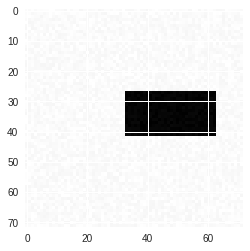

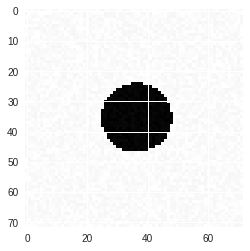

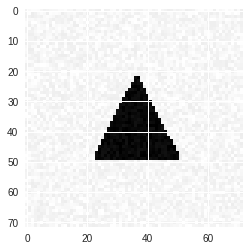

In [6]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

In [8]:
# Generating the training dataset
[X_train, Y_train] = generate_dataset_classification(300, 20)


Creating data:
0
100
200


In [9]:
Y_train_categorical = to_categorical(Y_train, num_classes=3)
model = Sequential()

model.add(Dense(3, input_dim=5184, kernel_initializer='normal', activation='relu'))
model.add(Dense(3, kernel_initializer='normal', activation='sigmoid'))

sgdOptimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# model.compile(loss='categorical_crossentropy', optimizer=sgdOptimizer, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train_categorical, epochs=50, batch_size=16, verbose=1)


Epoch 1/50
300/300 [==============================] - 1s 2ms/step - loss: 1.0843 - acc: 0.3167
Epoch 2/50
300/300 [==============================] - 0s 129us/step - loss: 1.0386 - acc: 0.4500
Epoch 3/50
300/300 [==============================] - 0s 133us/step - loss: 0.9845 - acc: 0.5300
Epoch 4/50
300/300 [==============================] - 0s 142us/step - loss: 0.9298 - acc: 0.5300
Epoch 5/50
300/300 [==============================] - 0s 129us/step - loss: 0.8956 - acc: 0.6200
Epoch 6/50
300/300 [==============================] - 0s 133us/step - loss: 0.8628 - acc: 0.6467
Epoch 7/50
300/300 [==============================] - 0s 135us/step - loss: 0.8457 - acc: 0.6633
Epoch 8/50
300/300 [==============================] - 0s 135us/step - loss: 0.8318 - acc: 0.6767
Epoch 9/50
300/300 [==============================] - 0s 144us/step - loss: 0.8258 - acc: 0.6733
Epoch 10/50
300/300 [==============================] - 0s 140us/step - loss: 0.8201 - acc: 0.6767
Epoch 11/50
300/300 [==========

In [0]:
# TODO: Plots of loss and accuracy, SGD and Adam 

In [11]:
X_test = generate_a_disk(10)
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 1., 0.]], dtype=float32)

In [12]:
print(model.get_weights()[0].shape)
print(len(model.get_weights()))

(5184, 3)
4


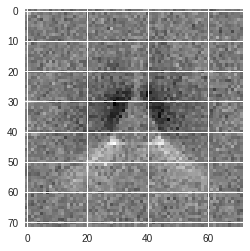

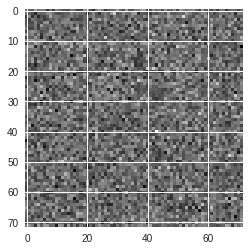

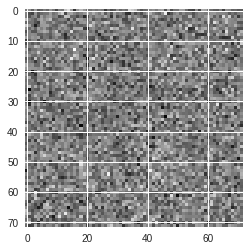

In [13]:
for j in range(3):
    plt.imshow(model.get_weights()[0][:,j].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.show()

In [16]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train_categorical = np_utils.to_categorical(Y_train, num_classes=3)

Creating data:
0
100
200


In [17]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
100
200


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train_categorical, epochs=100, batch_size=8, verbose=1)

Epoch 1/100
300/300 [==============================] - 0s 714us/step - loss: 1.1908 - acc: 0.3400
Epoch 2/100
300/300 [==============================] - 0s 208us/step - loss: 1.1455 - acc: 0.3467
Epoch 3/100
300/300 [==============================] - 0s 227us/step - loss: 1.1748 - acc: 0.3267
Epoch 4/100
300/300 [==============================] - 0s 229us/step - loss: 1.1482 - acc: 0.3467
Epoch 5/100
300/300 [==============================] - 0s 210us/step - loss: 1.1330 - acc: 0.3600
Epoch 6/100
300/300 [==============================] - 0s 208us/step - loss: 1.1227 - acc: 0.3900
Epoch 7/100
300/300 [==============================] - 0s 232us/step - loss: 1.0979 - acc: 0.4267
Epoch 8/100
300/300 [==============================] - 0s 214us/step - loss: 1.0887 - acc: 0.4233
Epoch 9/100
300/300 [==============================] - 0s 217us/step - loss: 1.0630 - acc: 0.4367
Epoch 10/100
300/300 [==============================] - 0s 195us/step - loss: 1.0539 - acc: 0.4300
Epoch 11/100
300/30

In [19]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 207us/step


[0.880685342947642, 0.556666665871938]

In [32]:
nb_sample = 1000
[X_train, Y_train] = generate_dataset_classification(nb_sample, 20, True)
Y_train_categorical = np_utils.to_categorical(Y_train, num_classes=3)

Creating data:
0
100
200
300
400
500
600
700
800
900


In [34]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

def createModel():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

cnn_model = createModel()


X_train = X_train.reshape((nb_sample,IMAGE_SIZE,IMAGE_SIZE,1))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train, Y_train_categorical, epochs=10, batch_size=36, verbose=1)

Epoch 1/10
1000/1000 [==============================] - 27s 27ms/step - loss: 2.7492 - acc: 0.4610
Epoch 2/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.7111 - acc: 0.7040
Epoch 3/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.4617 - acc: 0.8290
Epoch 4/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.2207 - acc: 0.9510
Epoch 5/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.1056 - acc: 0.9760
Epoch 6/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0561 - acc: 0.9880
Epoch 7/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0453 - acc: 0.9900
Epoch 8/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0214 - acc: 0.9970
Epoch 9/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0105 - acc: 1.0000
Epoch 10/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0063 - acc: 0.9990


In [38]:
[X_test, Y_test] = generate_test_set_classification()

X_test = X_test.reshape((300,IMAGE_SIZE,IMAGE_SIZE,1))
cnn_model.evaluate(X_test, Y_test)

Creating data:
0
100
200
300/300 [==============================] - 2s 7ms/step


[0.255686594247818, 0.9199999992052714]

In [82]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
100
200


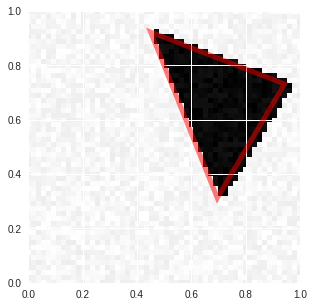

In [83]:
visualize_prediction(X_train[0], Y_train[0])

In [120]:
from sklearn.preprocessing import MinMaxScaler
# scalarXtrain, scalarYtrain = MinMaxScaler(), MinMaxScaler()
# scalarXtrain.fit(X_train)
# scalarYtrain.fit(Y_train.reshape(-1,1))
# X_train = scalarXtrain.transform(X_train)
# Y_train = scalarYtrain.transform(Y_train.reshape(-1,1))

scaler = MinMaxScaler()
print(scaler.fit(X_train))
print(scaler.fit(Y_train))
Y_train = scaler.transform(Y_train)
print(X_train[0].shape)

model = Sequential()
model.add(Dense(100, input_dim=5184))
model.add(Activation('tanh'))
model.add(Dense(6))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, Y_train, epochs=100, verbose=2)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
(5184,)


ValueError: ignored

In [116]:
[X_test, Y_test] = generate_test_set_regression()

scalerTest = MinMaxScaler()

print(scalerTest.fit(X_test))
print(scalerTest.fit(Y_test))
Y_test = scalerTest.transform(Y_test)

Creating data:
0
100
200
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


In [117]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 4ms/step


[0.08431985825300217, 0.08431985825300217]

In [121]:
y_pred = model.predict(X_test)
X_test

array([[0.97971582, 0.98408924, 0.9952138 , ..., 0.96632057, 0.96371418,
        0.99983144],
       [0.980205  , 0.9494385 , 0.99064977, ..., 0.98630824, 0.94669241,
        0.95031914],
       [0.97088494, 0.99175157, 0.94548286, ..., 0.95201227, 0.98255148,
        0.96649708],
       ...,
       [0.9523247 , 0.97840249, 0.93896908, ..., 0.98016863, 0.99638629,
        0.95958723],
       [0.93346973, 0.95200522, 0.93995049, ..., 0.95783797, 0.99963013,
        0.96107242],
       [0.98362736, 0.97104303, 0.96238696, ..., 0.95144482, 0.95233239,
        0.99051286]])